In [1]:
import quandl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
from sklearn.externals import joblib

In [3]:

start_date_string = '2014-04-01'
asset = 'BITFINEX/BTCUSD'
column_price = 'Last'
column_high = 'High'
column_low = 'Low'
column_volume = 'Volume'

quandl.ApiConfig.api_key = 'j-w1zbWv8xxzRgkDpX9k'
dataset = quandl.get(asset, collapse = 'daily',
                     trim_start = start_date_string)

In [7]:
dataset.shift(1).head()

High     Low      Mid    Last     Bid     Ask        Volume
Date                                                                    
2014-04-15    NaN     NaN      NaN     NaN     NaN     NaN           NaN
2014-04-16  513.9  452.00  504.235  505.00  503.50  504.97  21013.584774
2014-04-17  547.0  495.00  537.500  538.00  537.00  538.00  29633.358705
2014-04-18  538.5  486.10  507.020  508.00  506.04  508.00  20709.783819
2014-04-19  509.0  474.25  483.770  482.75  482.75  484.79  10458.045243

In [8]:
dataset.head()

High     Low        Mid      Last       Bid     Ask  \
Date                                                                  
2014-04-15  513.9000  452.00  504.23500  505.0000  503.5000  504.97   
2014-04-16  547.0000  495.00  537.50000  538.0000  537.0000  538.00   
2014-04-17  538.5000  486.10  507.02000  508.0000  506.0400  508.00   
2014-04-18  509.0000  474.25  483.77000  482.7500  482.7500  484.79   
2014-04-19  513.9899  473.83  505.01065  507.4999  502.5313  507.49   

                  Volume  
Date                      
2014-04-15  21013.584774  
2014-04-16  29633.358705  
2014-04-17  20709.783819  
2014-04-18  10458.045243  
2014-04-19   8963.618369

In [9]:
dataset = dataset.shift(1)

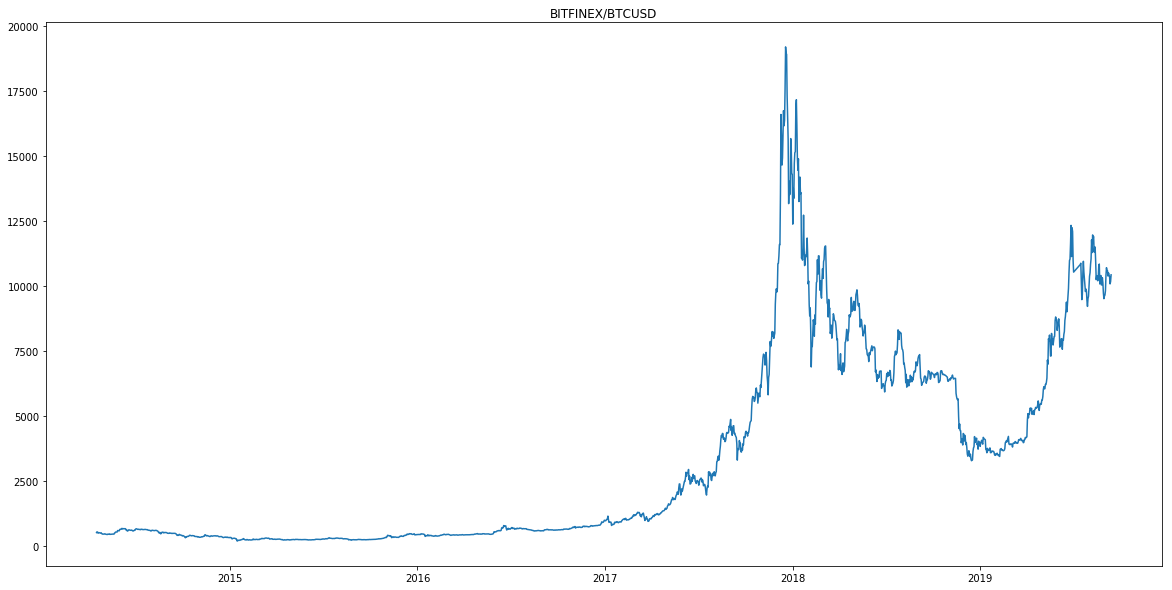

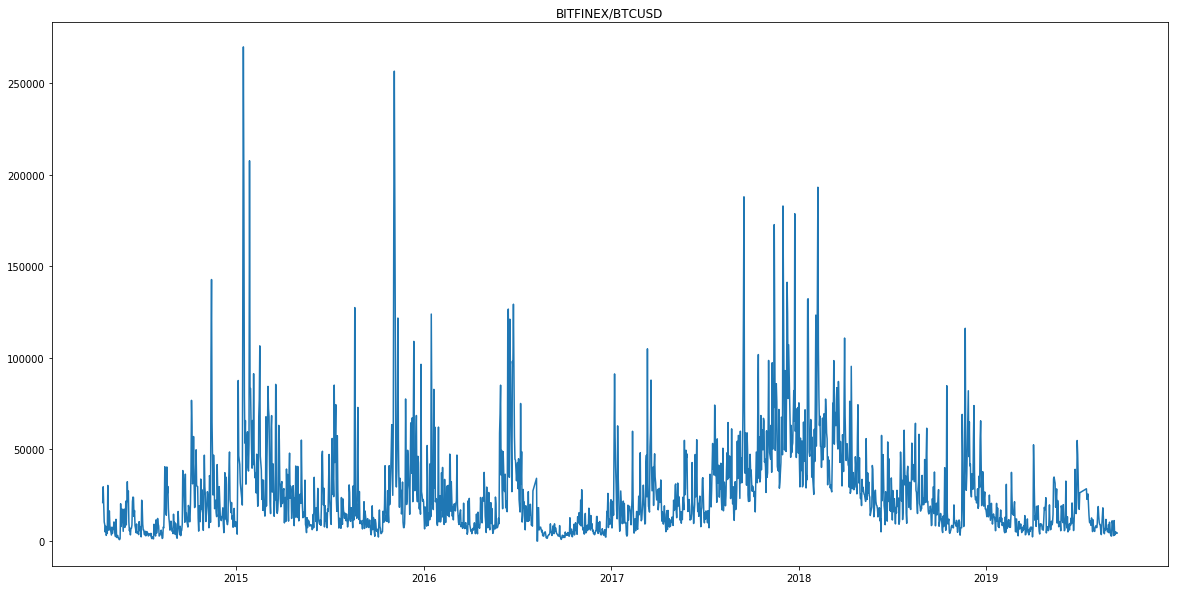

In [11]:
plt.figure(figsize=(20,10))
plt.plot(dataset[column_price])
plt.title(asset)
plt.show()
    
plt.figure(figsize=(20,10))
plt.plot(dataset[column_volume])
plt.title(asset)
plt.show()

In [12]:
def get_best_hmm_model(X,max_states,max_iter=10000):
    best_score = -(10**10)
    best_score = 0
    
    for state in range(1,max_states+1):
        hmm_model = GaussianHMM(n_components=state ,random_state=100 , covariance_type = "diag", n_iter=max_iter).fit(X)
        tmp_score = hmm_model.score(X)
        if tmp_score > best_score:
            best_score = tmp_score
            best_state = state
        best_model = GaussianHMM(n_components=best_state ,random_state=100 , covariance_type = "diag", n_iter=max_iter).fit(X)
        return best_model


In [13]:
# Normalized st. deviation
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# Ratio of diff between last price and mean value to last price
def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

# z-score for volumes and price
def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)

In [14]:
# Feature params
future_period = 1
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']
dataset['last_return'] = dataset[column_price].pct_change()
dataset['std_normalized'] = dataset[column_price].rolling(std_period).apply(std_normalized)
dataset['ma_ratio'] = dataset[column_price].rolling(ma_period).apply(ma_ratio)
dataset['price_deviation'] = dataset[column_price].rolling(price_deviation_period).apply(values_deviation)
dataset['volume_deviation'] = dataset[column_volume].rolling(volume_deviation_period).apply(values_deviation)

dataset["future_return"] = dataset[column_price].pct_change(future_period).shift(-future_period)

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()



C:\Users\PCLFin07\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PCLFin07\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':
C:\Users\PCLFin07\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this w

<Figure size 1440x720 with 0 Axes>

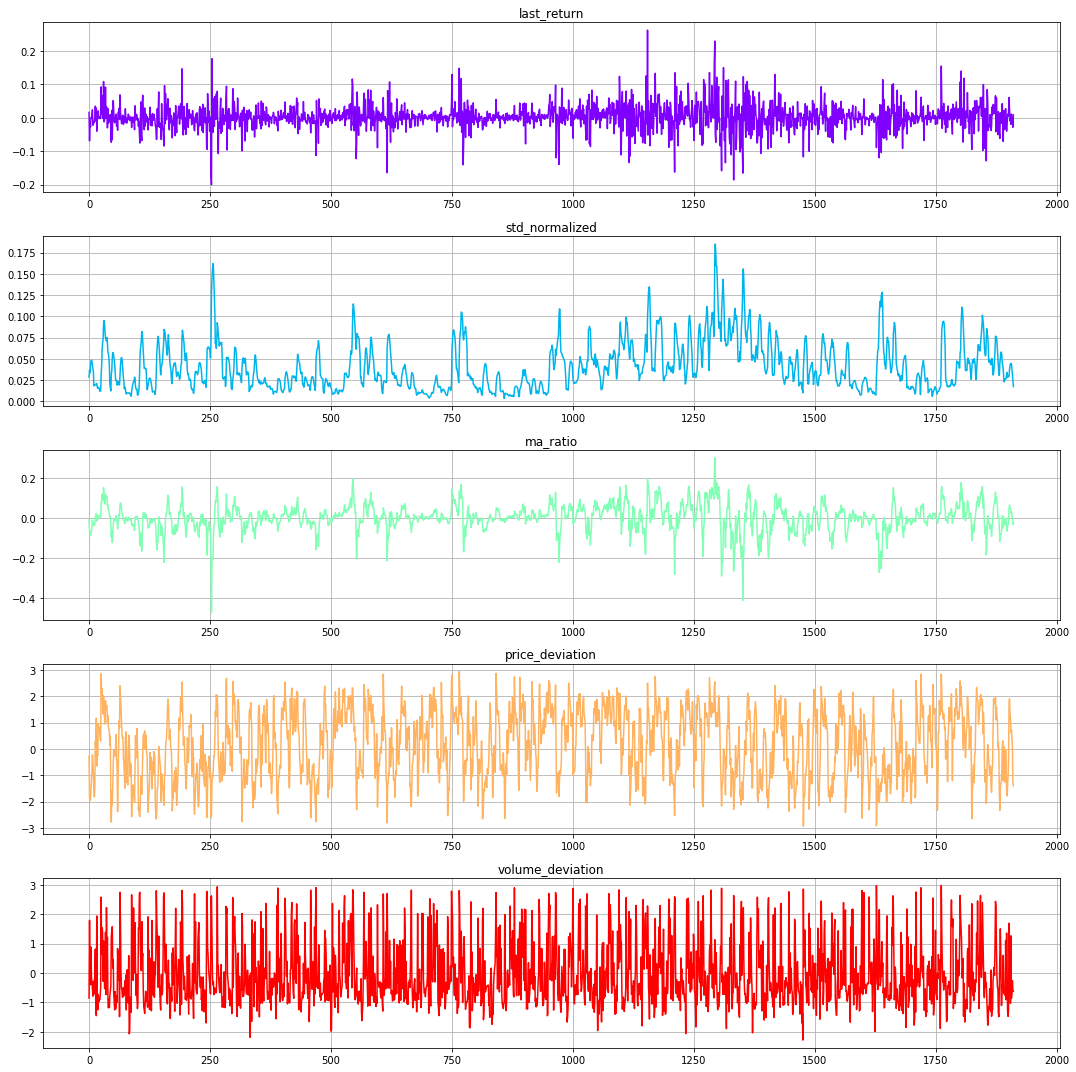

In [15]:
# Split the data on sets

train_ind = int(np.where(dataset.index == '2018-01-01 00:00:00')[0])
train_set = dataset[cols_features].values[:train_ind]
test_set = dataset[cols_features].values[train_ind:]

# Plot features
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(len(cols_features), 1, figsize = (15, 15))
colours = cm.rainbow(np.linspace(0, 1, len(cols_features)))
for i in range(0, len(cols_features)):
    axs[i].plot(dataset.reset_index()[cols_features[i]], color = colours[i])
    axs[i].set_title(cols_features[i])
    axs[i].grid(True)

plt.tight_layout()

In [19]:
cols_features

['last_return',
 'std_normalized',
 'ma_ratio',
 'price_deviation',
 'volume_deviation']

In [34]:
model = GaussianHMM(n_components=3 ,random_state=100 , covariance_type = "diag", n_iter=10000).fit(train_set)

In [35]:
model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10000, params='stmc',
      random_state=100, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

<Figure size 1080x1080 with 0 Axes>

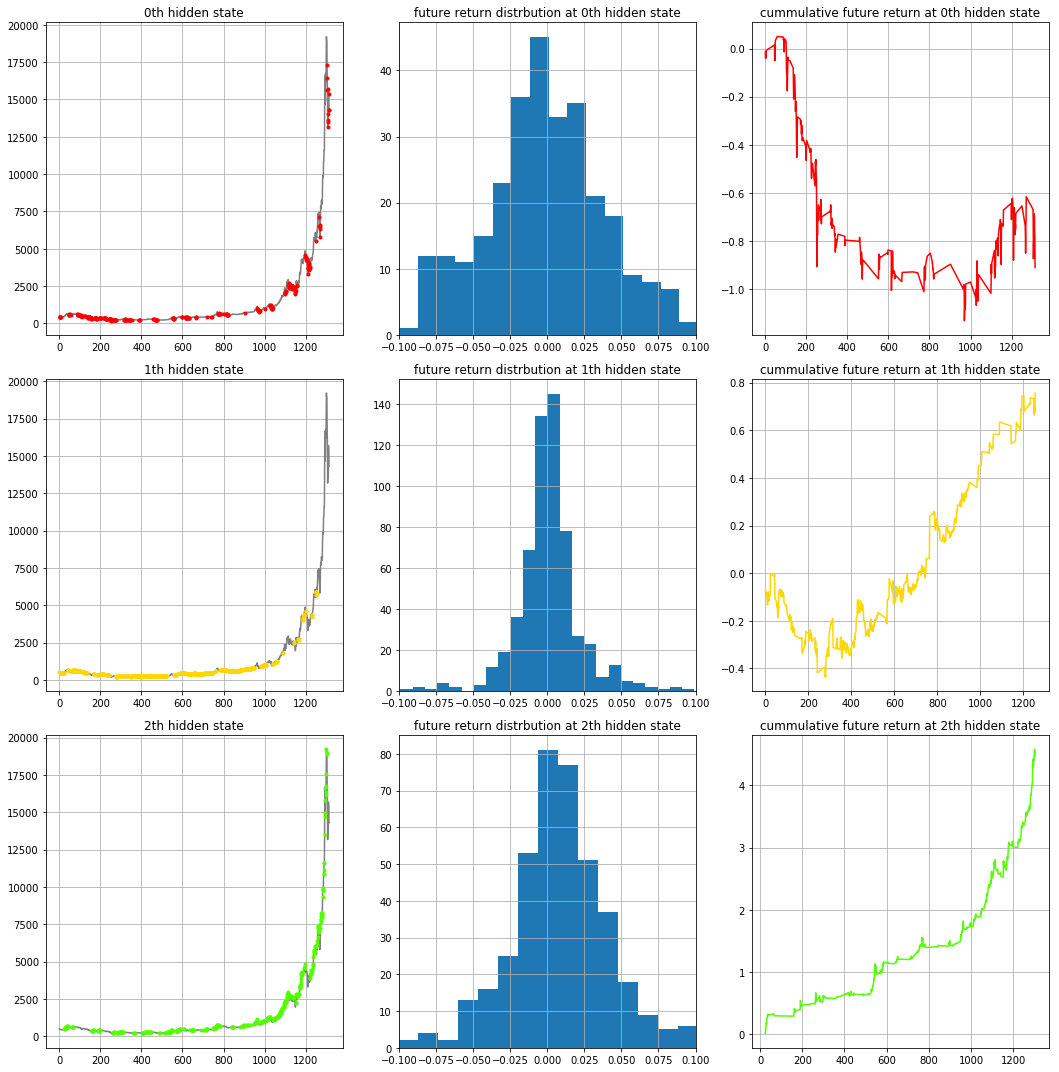

In [36]:

# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = model.predict(X)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()

plot_hidden_states(model, dataset[:train_ind].reset_index(), train_set, column_price)


In [53]:
a = model._generate_sample_from_state(0)
b = np.transpose(a)
print(a,a.shape)
print(b,b.shape)

[ 0.01018273  0.04458525 -0.05264123 -1.33077003 -0.44119249] (5,)
[ 0.01018273  0.04458525 -0.05264123 -1.33077003 -0.44119249] (5,)


In [55]:
row = np.transpose(model._generate_sample_from_state(0))
pd.DataFrame(row).T

0         1         2         3         4
0 -0.000525  0.063053 -0.187007 -1.010199 -0.165093

In [56]:
def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

def compare_hidden_states(hmm_model, cols_features, conf_interval, iters = 1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0, model.n_components):
        mc_df = pd.DataFrame()
    
        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features
    
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + " (state " + str(i) + "): " + str(np.round(mean_confidence_interval(mc_df[cols_features[k]], conf_interval), 3)))
            axs[k][i].grid(True)
            
    plt.tight_layout()

<Figure size 1080x1080 with 0 Axes>

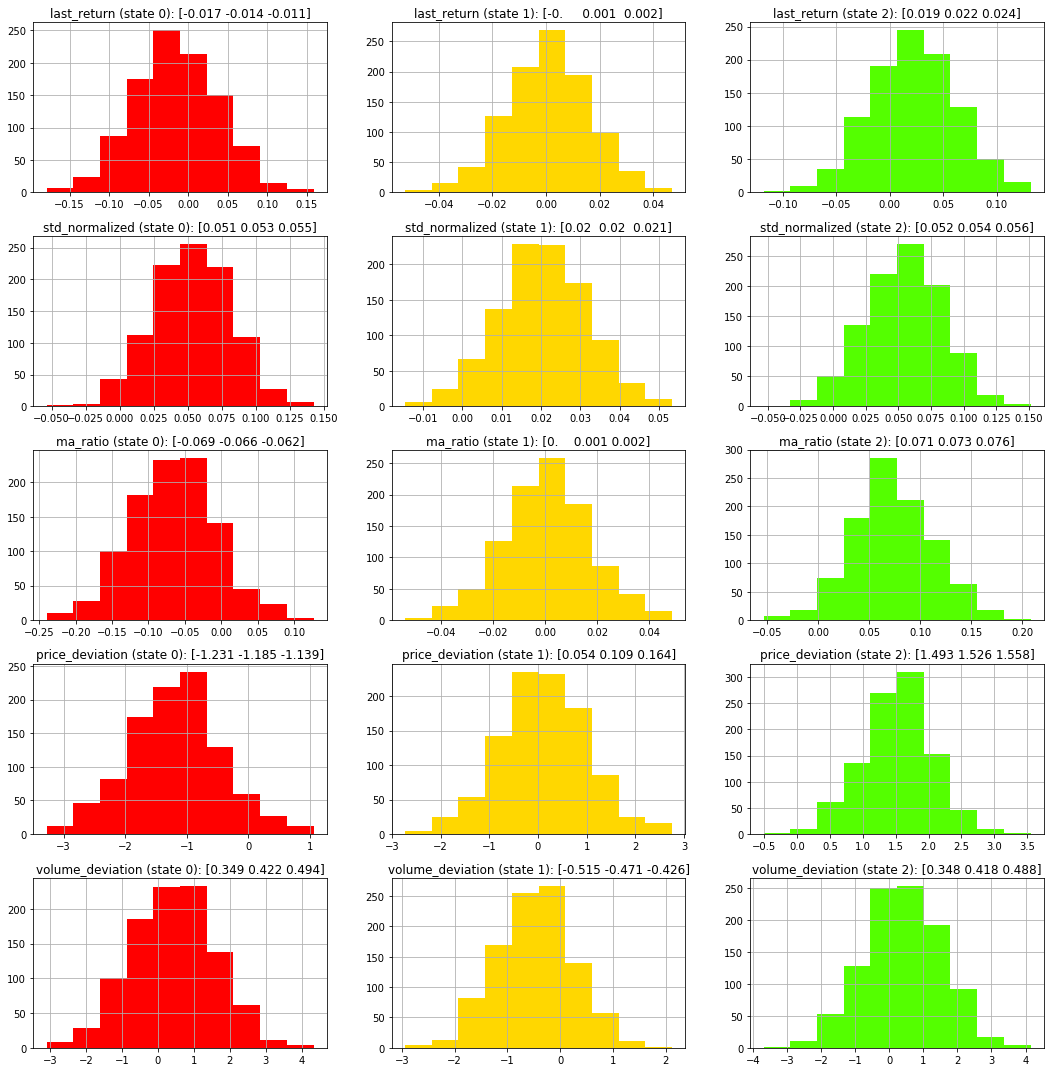

In [57]:
compare_hidden_states(hmm_model=model, cols_features=cols_features, conf_interval=0.95)

In [58]:
joblib.dump(model, 'quandl_' + asset.replace('/', '_') + '_final_model.pkl')

['quandl_BITFINEX_BTCUSD_final_model.pkl']

#### If the market has the current state #0 we have mostly downside market condition (second key) at the current situation, and this tendency will go on (first key).
#### If the market has the current state #1 we have the uncertainty for the tendency.
#### If the market has the current state #2 we have mostly upside market condition (second key) at the current situation, and this tendency will go on (first key).

#### 将模型保存起来，并用在测试集上
#### 策略
#### The logic is simple: short when state #0, no position when state #1, long when state #2.